# **Master’s in Applied Artificial Intelligence**
## **Course: Artificial Intelligence and Machine Learning**
### Prof. Luis Eduardo Falcón Morales
#### Tecnológico de Monterrey

### **Forecasts with time series**
##### **Name and student ID:**
* Mario Guillen de la Torre - A01796701

## **Data preprocessing**

In [4]:
## +++++++++
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [5]:
data_df = pd.read_csv('monthly_champagne_sales.csv')
data_df.columns = ['ds', 'y']
data_df['ds'] = pd.to_datetime(data_df['ds'])

In [6]:
df_temp = data_df.copy().set_index('ds')
df_temp.index.freq = 'MS'

train = df_temp.iloc[0:-12,:]
test = df_temp.iloc[-12:,:]

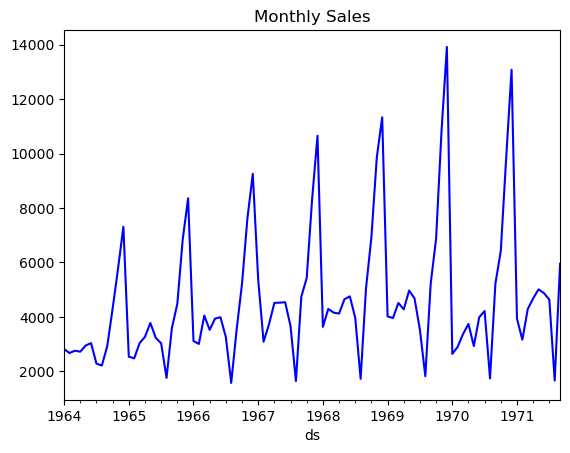

In [7]:
train['y'].plot(title='Monthly Sales', style='-b')
plt.show()

## **Naive model**

### **Model generation and RMSE calculation**


In [10]:
history = [train['y'].values[-1]]
predictions = list()

In [11]:
for i in range(len(test['y'])):
  yhat = history[-1]
  predictions.append(yhat)

  obs = test.iloc[i]['y']
  history.append(obs)
  print('>Real-value = %3d, Prediction = %.3f' % (obs, yhat))
rmseInge = np.sqrt(mean_squared_error(test['y'].values, predictions))
print("Length of test:", len(test['y'].values))
print("Length of predictions:", len(predictions))
print('\n Naive-Model-Error: RMSE: %.3f' % rmseInge)

>Real-value = 6981, Prediction = 5951.000
>Real-value = 9851, Prediction = 6981.000
>Real-value = 12670, Prediction = 9851.000
>Real-value = 4348, Prediction = 12670.000
>Real-value = 3564, Prediction = 4348.000
>Real-value = 4577, Prediction = 3564.000
>Real-value = 4788, Prediction = 4577.000
>Real-value = 4618, Prediction = 4788.000
>Real-value = 5312, Prediction = 4618.000
>Real-value = 4298, Prediction = 5312.000
>Real-value = 1413, Prediction = 4298.000
>Real-value = 5877, Prediction = 1413.000
Length of test: 12
Length of predictions: 12

 Naive-Model-Error: RMSE: 3135.480


### Graph of predictions and real data


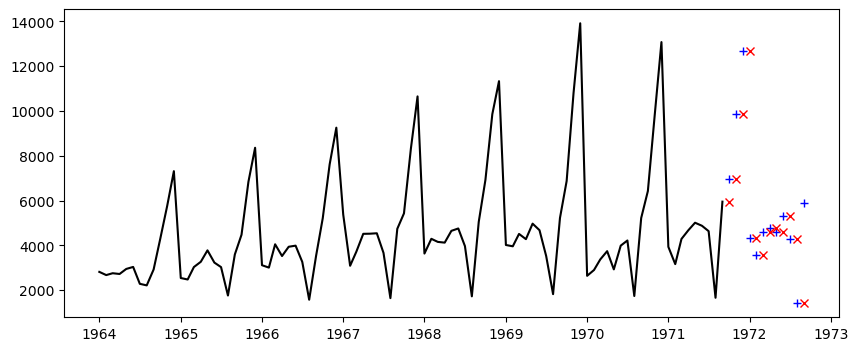

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '+b')
ax = plt.plot(test.index, predictions, 'xr')

## **Arima Model**

### **Prior data analysis**

With the graphs generated we can observe that our data set agrees with a multiplicative model (the ridges and valleys of the cyclic pattern are increasing in each iteration). In addition, there is a clear annual pattern.

We can also see that those who are looking for are from 0 to 12 and the P are 1 to 2.


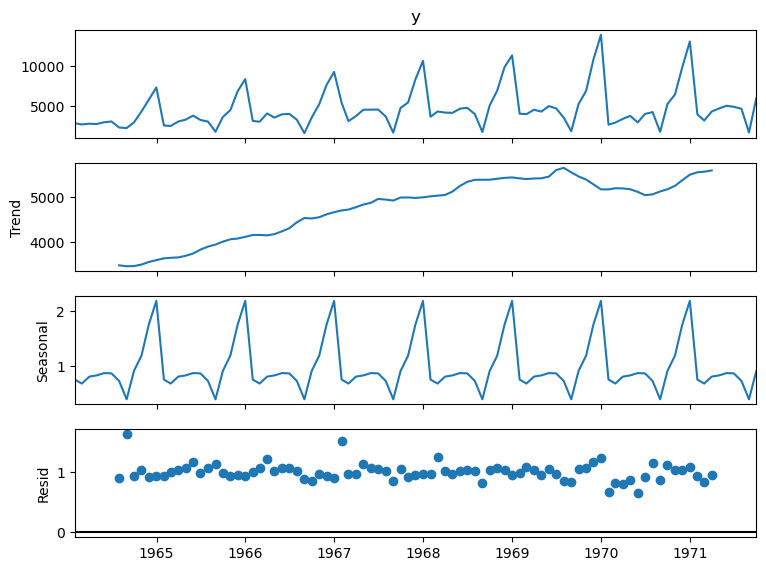

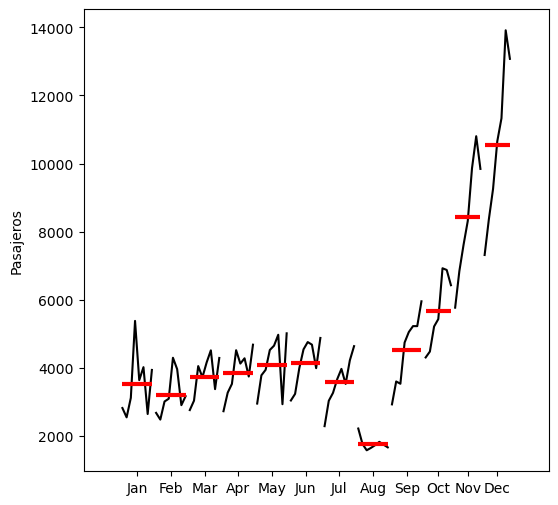

In [17]:
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

fig = month_plot(train['y'].resample('M').mean(), ylabel='Pasajeros')
fig.set_size_inches(6,6)
plt.show()

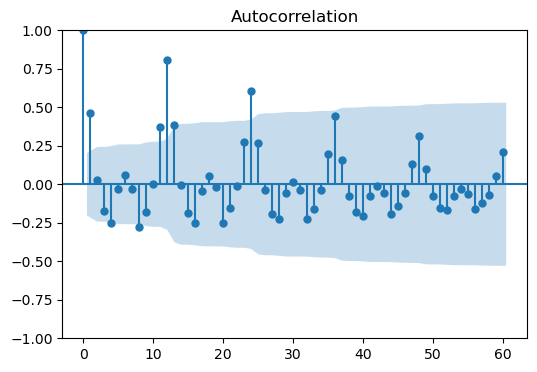

In [18]:
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)
plt.show()

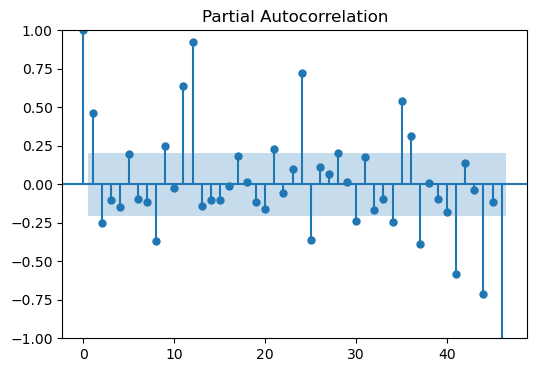

In [19]:
# Partial Autocorrelation Graph (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 46, ax = ax, method="ols") 
plt.show()

### **Model generation and RMSE calculation**

We are looking for the best hyperparameters making a manual gridsearch that Itere on the values of Q and P above, then the model to generate the graph is generated again.

In [22]:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)

def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [23]:
pValues = [x for x in range(0, 13)]
qValues = [0,1,2]
best_rmse_ARIMA = float('inf')
best_values_ARIMA = [0,0]

diff = difference(train['y'].tolist(), 12)

In [24]:
for p in pValues:
  for q in qValues:
    model = ARIMA(diff, order=(p,0,q),)
    model_fit = model.fit(method_kwargs={'maxiter':500})

    history = train['y'].tolist()
    predictions = list()

    for i in range(len(test['y'])):
      yhat = model_fit.forecast()[0]
      yhat = inverse_difference(history, yhat, 12)
      predictions.append(yhat)

      obs = test.iloc[i]['y']
      history.append(obs)

    rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
    if rmse < best_rmse_ARIMA:
      best_rmse_ARIMA = rmse
      best_values_ARIMA = [p,q]


In [25]:
print('\n ARIMA-Model-Error: RMSE: %.3f, Q: %d P: %d' % (best_rmse_ARIMA,best_values_ARIMA[0],best_values_ARIMA[1]))


 ARIMA-Model-Error: RMSE: 339.951, Q: 10 P: 0


In [26]:
model = ARIMA(diff, order=(0,0,10),)
model_fit = model.fit(method_kwargs={'maxiter':500})

history = train['y'].tolist()
predictions = list()

for i in range(len(test['y'])):
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, 12)
  predictions.append(yhat)

  obs = test.iloc[i]['y']
  history.append(obs)
rmseARI = np.sqrt(mean_squared_error(test['y'].values, predictions))

In [27]:
print('\n ARIMA-Model-Error: RMSE: %.3f' % rmseARI)


 ARIMA-Model-Error: RMSE: 342.497


### Graph of predictions and real data


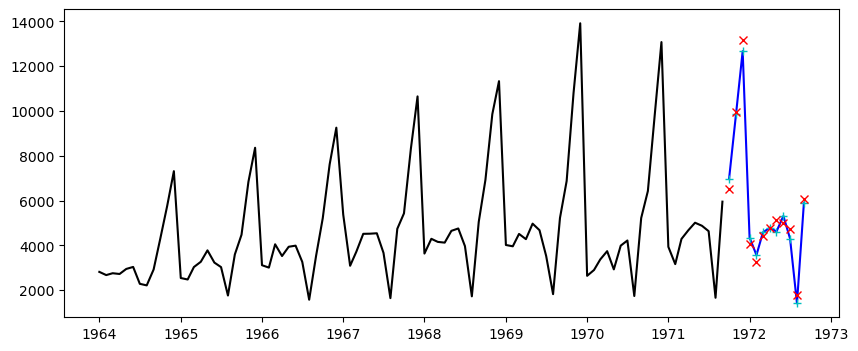

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

## Prophet model

### Model generation and RMSE calculation

We can make a manual Grid Search with the most important variables of the model and with prudent search ranges to find a low RMSE model.

In [33]:
train = data_df.iloc[0:-12,:]
test = data_df.iloc[-12:,:]

In [34]:
changeValues = [x for x in np.arange(.1, 1.0,.1)]
seasonalityValues = [x for x in np.arange(.1, 1.0,.1)]
changepoint_range  = [x for x in np.arange(.5, 1.0,.1)]
best_rmse_pro = float('inf')
best_values_pro = [0,0,0]

In [ ]:
for change in changeValues:
  for seasonality in seasonalityValues:
    for changepoint in changepoint_range:
      model = Prophet(seasonality_mode='multiplicative',
                      yearly_seasonality=True,
                      changepoint_prior_scale=change,
                      seasonality_prior_scale=seasonality,
                      changepoint_range=changepoint)
      model.fit(train)
      pred_FP = model.predict(test)['yhat']
      rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
      if rmse < best_rmse_pro:
        best_rmse_pro = rmse
        best_values_pro = [change,seasonality,changepoint]


20:12:58 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:13:00 - cmdstanpy - INFO - Chain [1] done processing
20:13:00 - cmdstanpy - INFO - Chain [1] start processing
20:13:00 - cmdstanpy - INFO - Chain [1] done processing
20:13:00 - cmdstanpy - INFO - Chain [1] start processing
20:13:01 - cmdstanpy - INFO - Chain [1] done processing
20:13:01 - cmdstanpy - INFO - Chain [1] start processing
20:13:01 - cmdstanpy - INFO - Chain [1] done processing
20:13:01 - cmdstanpy - INFO - Chain [1] start processing
20:13:02 - cmdstanpy - INFO - Chain [1] done processing
20:13:02 - cmdstanpy - INFO - Chain [1] start processing
20:13:02 - cmdstanpy - INFO - Chain [1] done processing
20:13:02 - cmdstanpy - INFO - Chain [1] start processing
20:13:02 - cmdstanpy - INFO - Chain [1]

In [ ]:
print('\nError-Modelo-Prophet: RMSE: %.3f, Change: %.2f Seasonality: %.2f, Changepoint: %.2f' % (best_rmse_pro,best_values_pro[0],best_values_pro[1],best_values_pro[2]))

In [ ]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=.30,
                seasonality_prior_scale=.10,
                changepoint_range=.7)
model.fit(train)

In [ ]:
pred_FP = model.predict(test)['yhat']
rmsePro = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\n FacebookProphet-Model-Error: RMSE: %.3f' % rmsePro)

### Real predictions and data graphics

In [ ]:
forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)
ax = plt.plot(test['ds'], test['y'], '*r')
ax = plt.plot(test['ds'], forecast['yhat'], '+c')


## **LSTM model**

### **Data preprocessing**

The data is processed to have the expected structure for the LSTM model, we also perform a minmax scaling to improve the model output.

In [ ]:
def sequence_creation(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
window_size = 12

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_temp['y'].values.reshape(-1, 1))
df_temp_scaled = pd.DataFrame(data_scaled, columns=['y'], index=df_temp.index)

X, y = sequence_creation(df_temp_scaled [['y']].values, window_size)

print(X.shape)

In [ ]:

split = len(X) - 24
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)
print(X_test.shape)

### **Model generation and RMSE calculation**

We build a six -layer network, three LSTM with a drop out layer between them and to finish a dense layer. In addition, training was maintained in 100 times to avoid overcoming.

In [ ]:
# We build a relatively simple sequential model based on LSTMS:
model = Sequential()
model.add(LSTM(60,  # Total LSTM layer neurons
               return_sequences=True, # to continue maintaining the 3 dimensions format.
               activation='tanh',
               recurrent_activation='sigmoid'
               ))  # LSTM layer
model.add(Dropout(0.2))

model.add(LSTM(50,  # Total LSTM layer neurons
               return_sequences=True, # to continue maintaining the 3 dimensions format.
               activation='tanh',
               recurrent_activation='sigmoid'
               ))  # LSTM layer
model.add(Dropout(0.1))

model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(1))  # Output layer

# We compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],   # Deploy RMSE
              )

# And we carry out training with training and proof cunjutes:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

In [ ]:
pred_LSTM = scaler.inverse_transform(model.predict(X_test[-12:]))
y_test_real = scaler.inverse_transform(y_test[-12:].reshape(-1, 1))

rmseLSTM = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\n FacebookProphet-Model-Error: RMSE: %.3f' % rmseLSTM)

### **Real predictions and data graphics**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(data_df['ds'][0:int(0.85 * len(data_df))], data_df['y'][0:int(0.85 * len(data_df))], '-k')
ax = plt.plot(data_df['ds'][int(0.85 * len(data_df)):], data_df['y'][int(0.85 * len(data_df)):], '-b')
ax = plt.plot(data_df['ds'][-12:], data_df['y'][-12:], '+c')
ax = plt.plot(data_df['ds'][-12:], pred_LSTM, 'xr')

## Comparison

When comparing the results, we can see that the Arima and Prophet method are quite close to each other, with Prophet taking the front for less than twenty points, making these incredibly strong methods for this type of case (few data with waste with average variance).

On the other hand, LSTM was third. The amount of data plays an important role in neuronal networks and this may be a contributing factor for its low performance. However, all models exceeded with a wide margin to the naive method.


In [ ]:
results = {'Method'    : ['Ingenuo','ARIMA','Prophet','LSTM'],
              'Result' : [rmseInge,rmseARI,rmsePro,rmseLSTM]}
results_df = pd.DataFrame(results)

In [ ]:
ax = sns.barplot(x='Method', y='Result', data=results_df)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")
plt.show()

## ** <<< End of the week's activity - forecasts and time series >>> **